In [1]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.regressor import PredictionError
from yellowbrick.regressor import prediction_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, mutual_info_regression

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
base_path = '/kaggle/input/self-reported-qol/20230625-processed-'

df_physical      = pd.read_csv(base_path + 'physical-qol.csv')
df_psychological = pd.read_csv(base_path + 'psychological-qol.csv')

df_physical.drop('id', axis=1, inplace=True)         # id
df_physical.drop('day', axis=1, inplace=True)        # day
df_psychological.drop('id', axis=1, inplace=True)    # id
df_psychological.drop('day', axis=1, inplace=True)   # day

phy_all_tmp = df_physical.copy()
phy_init_set_tmp = phy_all_tmp.query("group in ('Initial Set')").copy()
phy_ufpi_ufc_tmp = phy_all_tmp.query("group in ('UFPI', 'UFC')").copy()

psy_all_tmp = df_psychological.copy()
psy_init_set_tmp = psy_all_tmp.query("group in ('Initial Set')").copy()
psy_ufpi_ufc_tmp = psy_all_tmp.query("group in ('UFPI', 'UFC')").copy()

phy_all_tmp.drop("group", axis=1, inplace=True)
phy_init_set_tmp.drop("group", axis=1, inplace=True)
phy_ufpi_ufc_tmp.drop("group", axis=1, inplace=True)

psy_all_tmp.drop("group", axis=1, inplace=True)
psy_init_set_tmp.drop("group", axis=1, inplace=True)
psy_ufpi_ufc_tmp.drop("group", axis=1, inplace=True)

# Separating predictors from the values to be predicted.
phy_all           = phy_all_tmp.drop("phy_ref_score", axis=1)
phy_all_pred      = phy_all_tmp["phy_ref_score"].copy()
phy_init_set      = phy_init_set_tmp.drop("phy_ref_score", axis=1)
phy_init_set_pred = phy_init_set_tmp["phy_ref_score"].copy()
phy_ufpi_ufc      = phy_ufpi_ufc_tmp.drop("phy_ref_score", axis=1)
phy_ufpi_ufc_pred = phy_ufpi_ufc_tmp["phy_ref_score"].copy()

psy_all           = psy_all_tmp.drop("psy_ref_score", axis=1)
psy_all_pred      = psy_all_tmp["psy_ref_score"].copy()
psy_init_set      = psy_init_set_tmp.drop("psy_ref_score", axis=1)
psy_init_set_pred = psy_init_set_tmp["psy_ref_score"].copy()
psy_ufpi_ufc      = psy_ufpi_ufc_tmp.drop("psy_ref_score", axis=1)
psy_ufpi_ufc_pred = psy_ufpi_ufc_tmp["psy_ref_score"].copy()

In [3]:
def print_corr(df, cmethod, feat):
    c = df.corr(method=cmethod, numeric_only=True)[[feat]].abs()
    s = c.unstack()
    print(s.sort_values(kind="quicksort"))

In [4]:
print_corr(df_physical, 'pearson', 'phy_ref_score')

phy_ref_score  whatsappinvideo       0.000834
               news                  0.001171
               differentlocations    0.001621
               weather               0.001754
               art                   0.001839
                                       ...   
               sdnn                  0.293896
               height                0.325405
               phy_ref_score         1.000000
               running(treadmill)         NaN
               strengthtraining           NaN
Length: 87, dtype: float64


In [5]:
print_corr(df_physical, 'kendall', 'phy_ref_score')

phy_ref_score  profession_selfemployed    0.000660
               weight                     0.003105
               photography                0.003731
               whatsappoutvideo           0.004097
               whatsappinvideo            0.006703
                                            ...   
               median_nni                 0.245635
               mean_nni                   0.252078
               phy_ref_score              1.000000
               running(treadmill)              NaN
               strengthtraining                NaN
Length: 87, dtype: float64


In [6]:
print_corr(df_physical, 'spearman', 'phy_ref_score')

phy_ref_score  profession_selfemployed    0.000780
               weight                     0.003414
               whatsappoutvideo           0.004751
               whatsappinvideo            0.007975
               photography                0.010111
                                            ...   
               median_nni                 0.336334
               mean_nni                   0.354188
               phy_ref_score              1.000000
               running(treadmill)              NaN
               strengthtraining                NaN
Length: 87, dtype: float64


In [7]:
print_corr(df_psychological, 'pearson', 'psy_ref_score')

psy_ref_score  whatsappinvideo       0.000294
               weather               0.001940
               sdnn                  0.002275
               cvnni                 0.003005
               maps                  0.003358
                                       ...   
               specificage           0.299543
               awakesleep            0.340610
               psy_ref_score         1.000000
               running(treadmill)         NaN
               strengthtraining           NaN
Length: 87, dtype: float64


In [8]:
print_corr(df_psychological, 'spearman', 'psy_ref_score')

psy_ref_score  games                 0.002591
               cvsd                  0.006996
               pnni_50               0.008153
               income                0.009376
               beauty                0.013921
                                       ...   
               shopping              0.312732
               awakesleep            0.380413
               psy_ref_score         1.000000
               running(treadmill)         NaN
               strengthtraining           NaN
Length: 87, dtype: float64


In [9]:
print_corr(df_psychological, 'kendall', 'psy_ref_score')

psy_ref_score  games                 0.000437
               pnni_50               0.004203
               cvsd                  0.007084
               income                0.009065
               pnni_20               0.010448
                                       ...   
               specificage           0.239938
               awakesleep            0.276601
               psy_ref_score         1.000000
               running(treadmill)         NaN
               strengthtraining           NaN
Length: 87, dtype: float64


In [10]:
def getDataset(domain_group):
    return {
        'phy_all': (phy_all, phy_all_pred),
        'psy_all': (psy_all, psy_all_pred),
        
        'phy_init_set': (phy_init_set, phy_init_set_pred),
        'psy_init_set': (psy_init_set, psy_init_set_pred),
        
        'phy_ufpi_ufc': (phy_ufpi_ufc, phy_ufpi_ufc_pred),
        'psy_ufpi_ufc': (psy_ufpi_ufc, psy_ufpi_ufc_pred),
    }[domain_group]

In [11]:
# https://www.scikit-yb.org/en/latest/api/regressor/residuals.html
# https://towardsdatascience.com/what-are-the-best-metrics-to-evaluate-your-regression-model-418ca481755b
def buildResidualGraph(domain_group, regressor, mytitle, filename):
    X, y = getDataset(domain_group)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)

    figure(figsize=(8, 4), dpi=300)
    visualizer = ResidualsPlot(regressor, title=" ")

    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    visualizer.show(outpath=filename)

In [12]:
# https://www.scikit-yb.org/en/latest/api/regressor/peplot.html
def buildPredictionErrorGraph(domain_group, regressor, mytitle, filename):
    X, y = getDataset(domain_group)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)

    figure(figsize=(8, 4), dpi=300)
    visualizer = PredictionError(regressor, title=" ")
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    visualizer.show(outpath=filename)

In [13]:
def get_rforest_phy():
    skb = SelectKBest(score_func=mutual_info_regression, k = 70)
    alg = RandomForestRegressor(warm_start=False, n_estimators=894, min_samples_split=5, min_samples_leaf=2, max_features=1.0, max_depth=10, criterion='squared_error', bootstrap=True, random_state=42)
    return Pipeline([('feat_selection', skb), ('regressor', alg)])

In [14]:
def get_rforest_psy():
    skb = SelectKBest(score_func=mutual_info_regression, k = 50)
    alg = RandomForestRegressor(warm_start=False, n_estimators=1778, min_samples_split=2, min_samples_leaf=1, max_features='sqrt', max_depth=None, criterion='poisson', bootstrap=False, random_state=42)
    return Pipeline([('feat_selection', skb), ('regressor', alg)])

In [15]:
def rmsle_cv(model, domain_group):
    start = time.time()
    
    X, y = getDataset(domain_group)
    kf = KFold(10, shuffle = True, random_state = 42).get_n_splits(X.values)
    rmse = np.sqrt(-cross_val_score(model, X.values, y, scoring = "neg_mean_squared_error", cv = kf))
    mae  = -cross_val_score(model, X.values, y, scoring = "neg_mean_absolute_error", cv = kf)
    r2 = cross_val_score(model, X.values, y, scoring = "r2", cv = kf)
    
    end = time.time()
    exec_time = end - start

    print('Time:', exec_time, 'MAE:', round(mae.mean(), 4), 'RMSE:',  round(rmse.mean(), 4), 'R^2:', round(r2.mean(), 4), '\n')

In [16]:
rmsle_cv(get_rforest_phy(), 'phy_all')
rmsle_cv(get_rforest_phy(), 'phy_init_set')
rmsle_cv(get_rforest_phy(), 'phy_ufpi_ufc')

Time: 683.6316571235657 MAE: 5.6594 RMSE: 7.95 R^2: 0.7264 

Time: 546.8090007305145 MAE: 4.8055 RMSE: 6.9256 R^2: 0.7731 

Time: 159.05331158638 MAE: 7.3477 RMSE: 10.0124 R^2: 0.5885 



In [17]:
rmsle_cv(get_rforest_psy(), 'psy_all')
rmsle_cv(get_rforest_psy(), 'psy_init_set')
rmsle_cv(get_rforest_psy(), 'psy_ufpi_ufc')

Time: 542.5806939601898 MAE: 5.38 RMSE: 7.4521 R^2: 0.765 

Time: 428.0355052947998 MAE: 4.0789 RMSE: 5.8198 R^2: 0.8272 

Time: 144.61858367919922 MAE: 8.0558 RMSE: 10.4258 R^2: 0.5481 



In [18]:
#sns.set_style("whitegrid", {'axes.grid' : False})

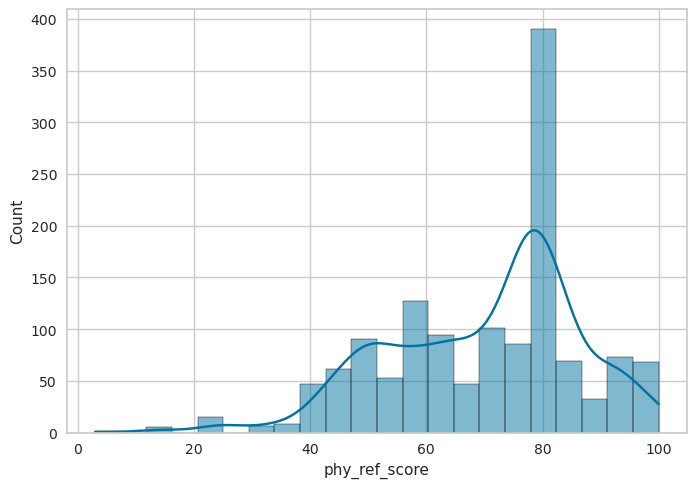

In [19]:
sns.histplot(data=df_physical, x="phy_ref_score", kde=True)
plt.show()

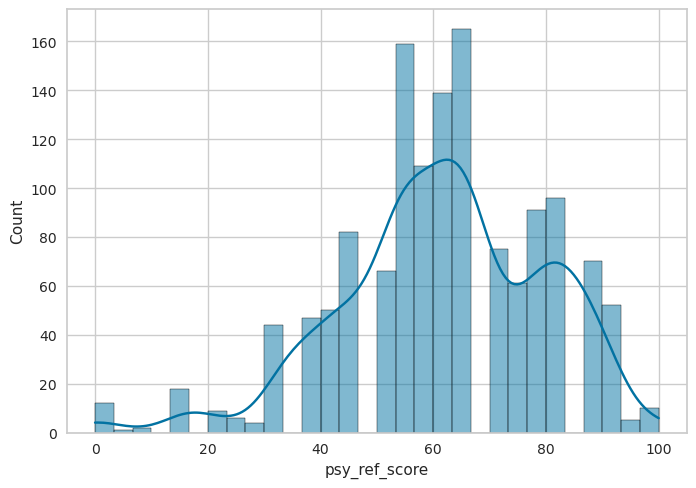

In [20]:
sns.histplot(data=df_psychological, x="psy_ref_score", kde=True, bins=30)
plt.show()

Time: 683.7357008457184 MAE: 5.6731 RMSE: 7.976 R^2: 0.7284 



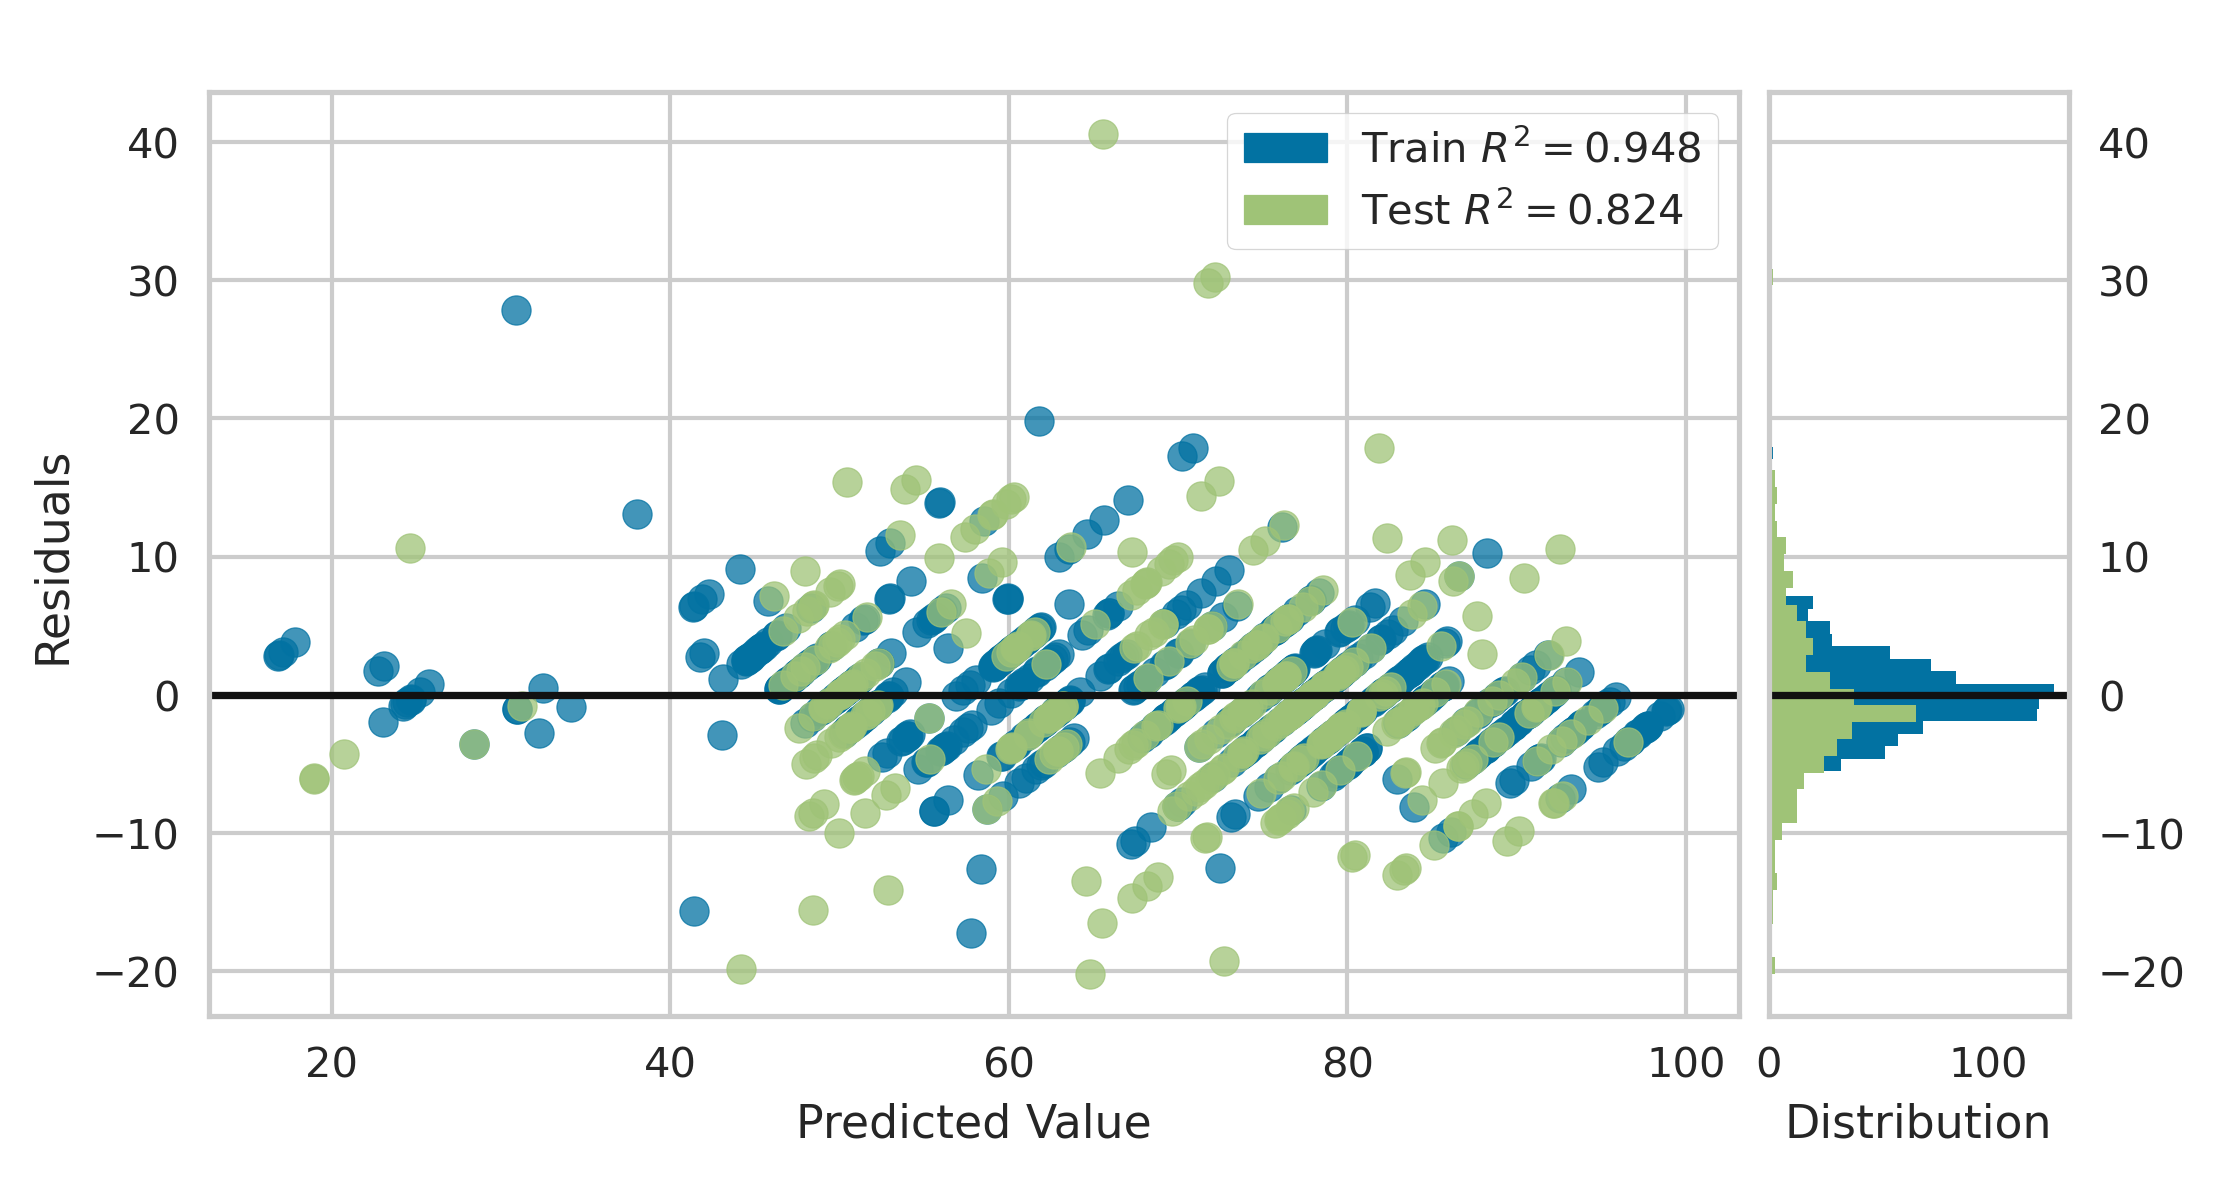

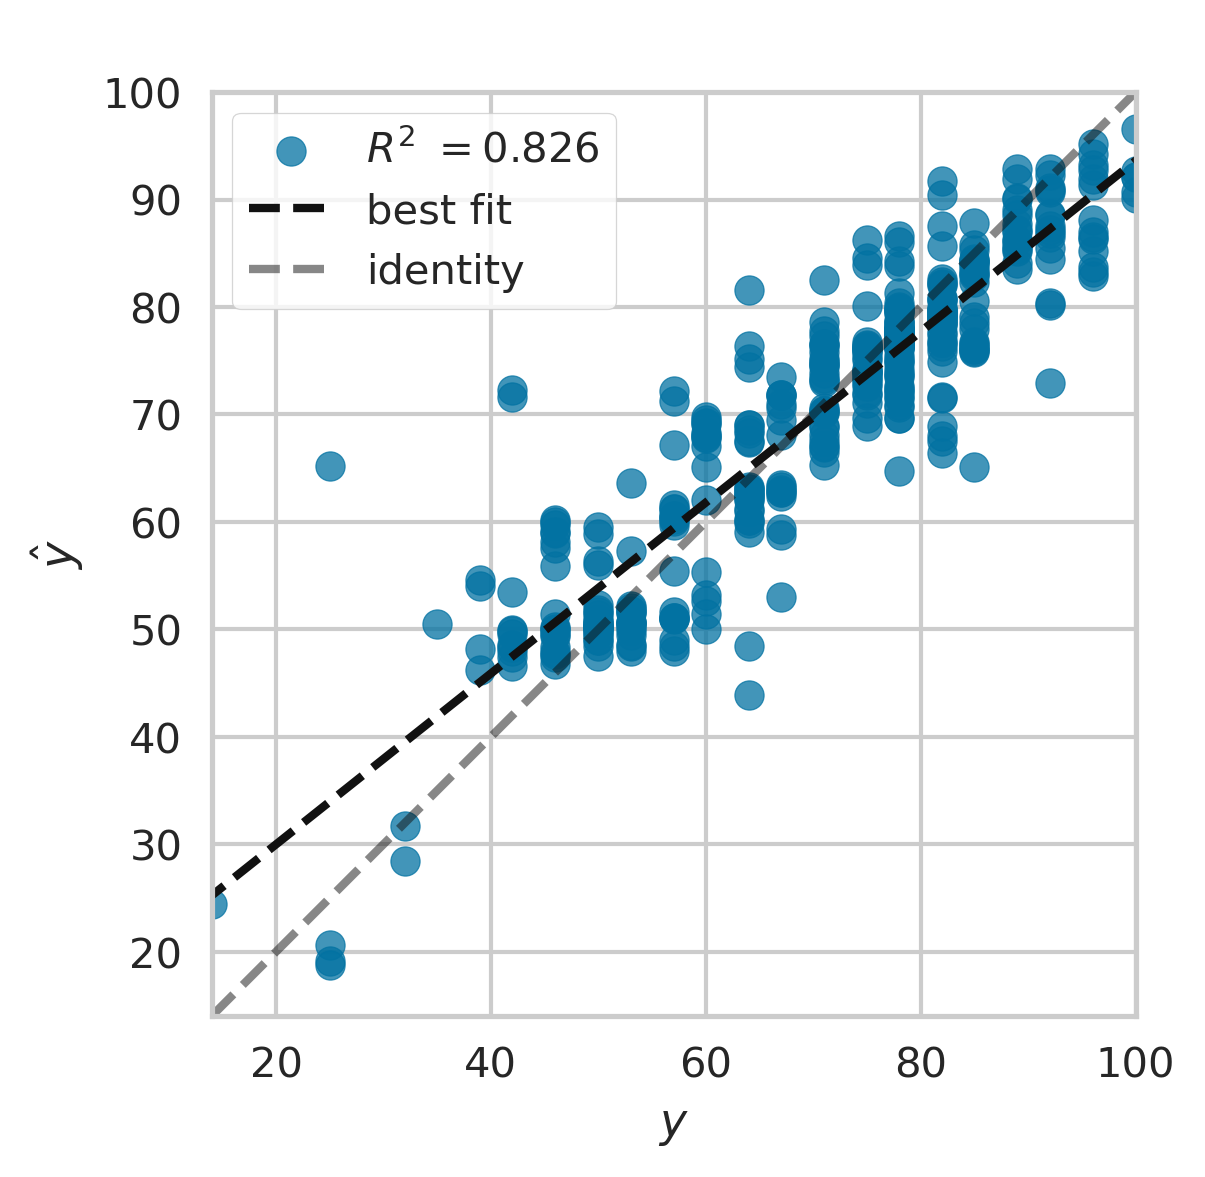

In [21]:
domain = 'phy_all'
rmsle_cv(get_rforest_phy(), domain)
buildResidualGraph(domain, get_rforest_phy(), 'Residuals for Random Forest Regressor considering Physical Dataset', 'residuals-phy-rforest.pdf')
buildPredictionErrorGraph(domain, get_rforest_phy(), 'Prediction Error for Random Forest Regressor considering Physical Dataset', 'errors-phy-rforest.pdf')

Time: 542.5572125911713 MAE: 5.3563 RMSE: 7.4539 R^2: 0.765 



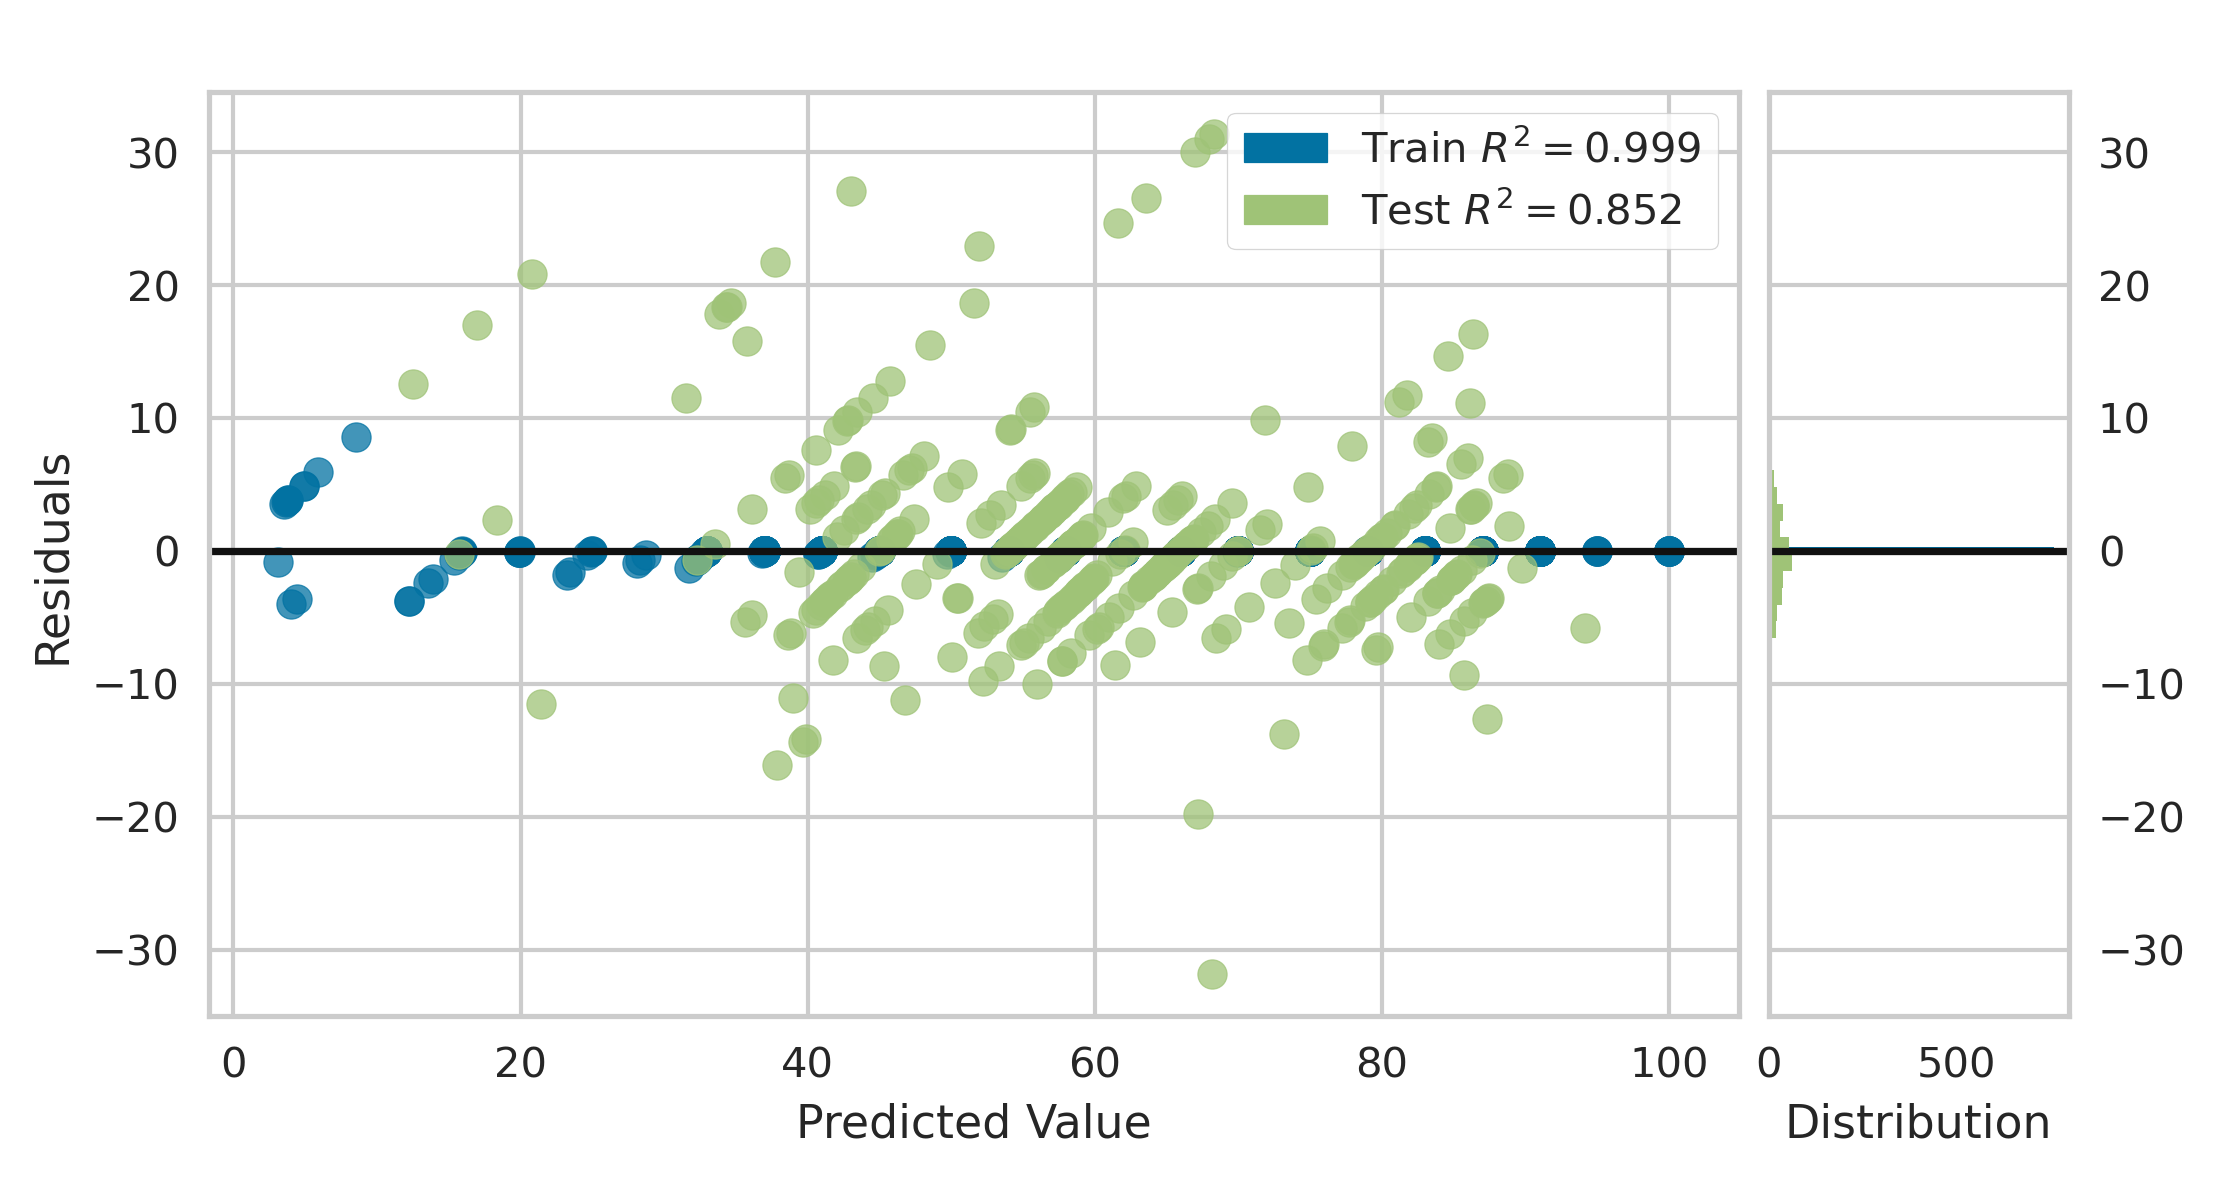

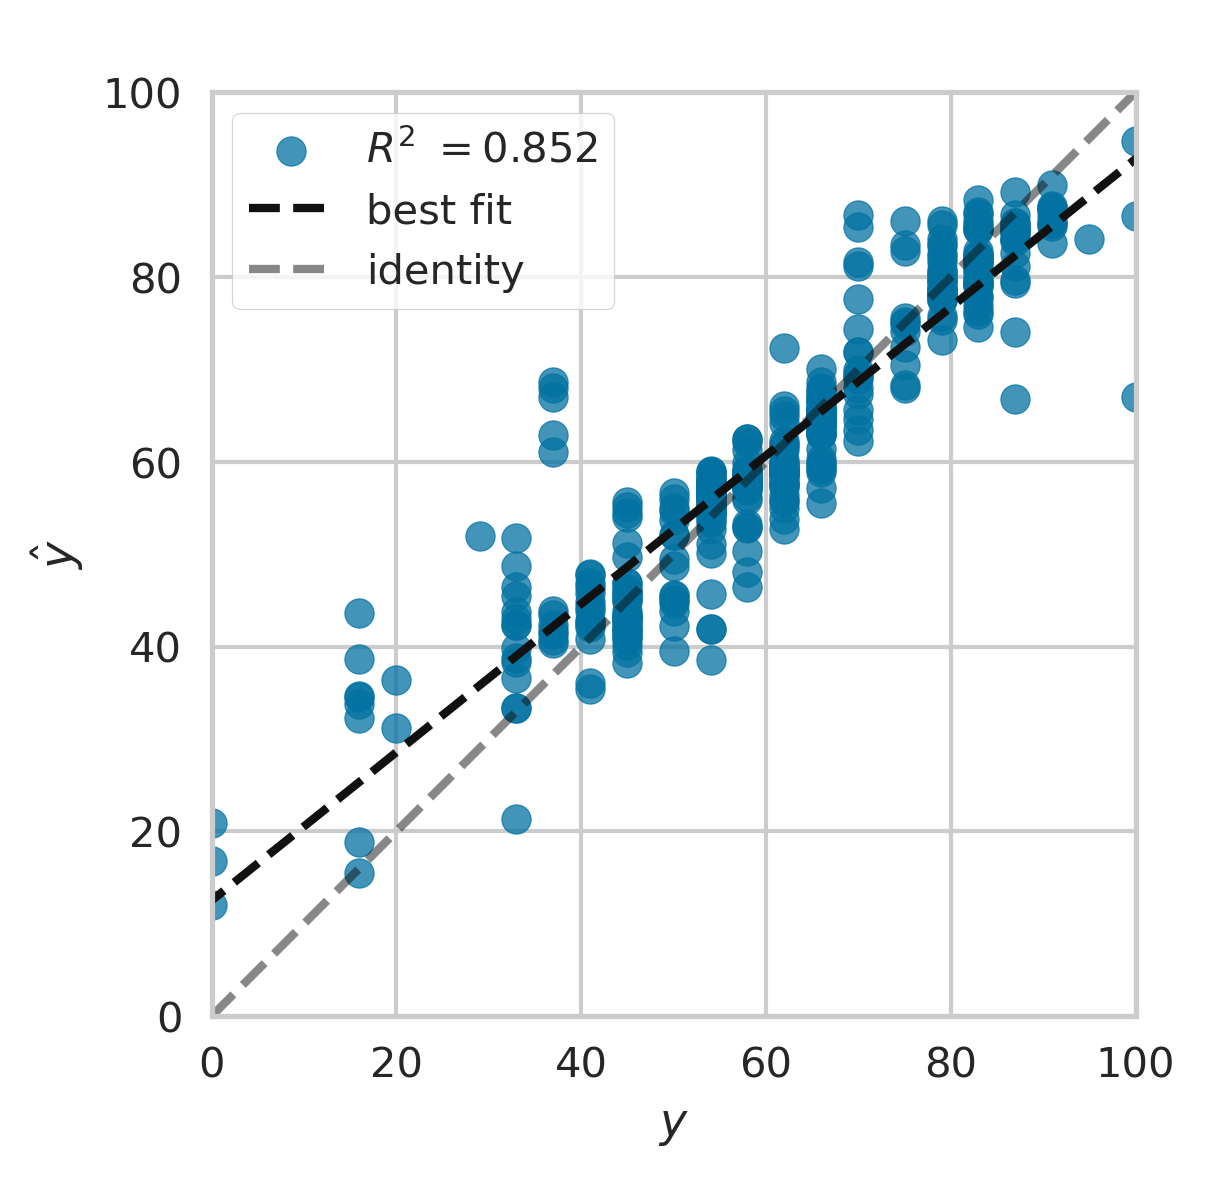

In [22]:
domain = 'psy_all'
rmsle_cv(get_rforest_psy(), domain)
buildResidualGraph(domain, get_rforest_psy(), 'Residuals for Random Forest Regressor considering Psychological Dataset', 'residuals-psy-rforest.pdf')
buildPredictionErrorGraph(domain, get_rforest_psy(), 'Prediction Error for Random Forest Regressor considering Psychological Dataset', 'errors-psy-rforest.pdf')

In [23]:
def get_20_most_df(domain, model, score_feat, dataframe):
    X, y = getDataset(domain)
    model.fit(X, y)

    feat_scores = model.steps[1][1].feature_importances_
    feat_importance = list(zip(X, feat_scores))
    sorted_feat_importance = sorted(feat_importance, key = lambda fi: fi[1], reverse=True)
    print('Feature relevance for', domain)
    print(sorted_feat_importance)
    
    twenty_most_important = []
    for index, fi in enumerate(sorted_feat_importance):
        if index < 20:
            twenty_most_important.append(fi[0])
        else:
            break
        
    twenty_most_important.append(score_feat)
    return dataframe[twenty_most_important]

In [24]:
df_phy_20_most = get_20_most_df('phy_all', get_rforest_phy(), 'phy_ref_score', df_physical)
df_phy_20_most.info()

Feature relevance for phy_all
[('weight', 0.30911628842668365), ('height', 0.2918266700933483), ('mean_hr', 0.06508768128878599), ('income', 0.05998969526328529), ('travel', 0.03648599835424153), ('gender', 0.027430863275198586), ('edulevel', 0.01478860734933375), ('min_hr', 0.012925824473597419), ('art', 0.011508625223310389), ('entertainment', 0.010242100377033408), ('calories', 0.0076509168750512075), ('communication', 0.007605496035013144), ('sdsd', 0.007160102949533321), ('whatsappinvideo', 0.007096275553765375), ('remsleep', 0.0063639317820093876), ('deepsleep', 0.005415174693840116), ('pnni_20', 0.005335277680855816), ('steps', 0.004872933616849423), ('whatsappoutvoice', 0.004847317955765274), ('music', 0.004257978737793661), ('shopping', 0.004209815785152226), ('residence', 0.004114742197293683), ('events', 0.004001872944598428), ('mean_nni', 0.0034719840952345763), ('sdnn', 0.0034255047659745804), ('blockedcalls', 0.003420539893575936), ('nni_20', 0.003221554543206263), ('nni_

In [25]:
df_psy_20_most = get_20_most_df('psy_all', get_rforest_psy(), 'psy_ref_score', df_psychological)
df_psy_20_most.info()

Feature relevance for psy_all
[('height', 0.11284396765768924), ('pnni_50', 0.09499419032002282), ('weight', 0.07820073025772285), ('deepsleep', 0.04148595247354795), ('cvsd', 0.040397018223387086), ('pnni_20', 0.0400063899185955), ('incomingcallsaverageduration', 0.03534527623429459), ('differentlocations', 0.03398550164901087), ('range_nni', 0.029385875888077603), ('mean_hr', 0.027223967577765795), ('entertainment', 0.026883659335858547), ('steps', 0.02258917545732908), ('median_nni', 0.020384383592273604), ('missedcalls', 0.019720254640830593), ('std_hr', 0.018898813697744175), ('lightsleep', 0.018110282805439484), ('blockedcalls', 0.01576812460801574), ('whatsappoutvoice', 0.015711771267371895), ('specificage', 0.015177864706895559), ('familyarr', 0.014515111186610193), ('gender', 0.014146288073207348), ('mean_nni', 0.01360080403728049), ('sdnn', 0.013431590414554141), ('communication', 0.013293409195260956), ('whatsappnotification', 0.01301319458450286), ('differentwifi', 0.012607

In [26]:
# https://realpython.com/numpy-scipy-pandas-correlation-python
def buildPearsonCorrelationMatrix(df_phy, df_psy, cmethod, filename):

    #figure(figsize=(8, 4), dpi=300)
    corr_phy = df_phy.corr(method=cmethod)
    corr_psy = df_psy.corr(method=cmethod)
    mask_phy = np.triu(np.ones_like(corr_phy))
    mask_psy = np.triu(np.ones_like(corr_psy))
    
    vmin = -1.0
    vmax = 1.0
    
    fig, axs = plt.subplots(ncols=3,figsize=(22,11), dpi=300, gridspec_kw=dict(width_ratios=[5,5,0.2]))
    fig.tight_layout(pad=8.0)
    axs[0].grid(False)
    axs[1].grid(False)
    sns.set(font_scale=1)
    #sns.set_style('white')
    first = sns.heatmap(corr_phy, cmap="coolwarm", annot=True, mask=mask_phy, fmt='.1f', ax=axs[0], cbar=False, vmin=vmin, vmax=vmax, linecolor='white')
    second = sns.heatmap(corr_psy, cmap="coolwarm", annot=True, mask=mask_psy, fmt='.1f', ax=axs[1], cbar=False, vmin=vmin, vmax=vmax, linecolor='white')
    fig.colorbar(axs[1].collections[0], cax=axs[2])
    plt.subplots_adjust(bottom=0.25)
    plt.gcf().subplots_adjust(bottom=0.25)
    first.set_xticklabels(first.get_xticklabels(), rotation=45, horizontalalignment='right')
    second.set_xticklabels(first.get_xticklabels(), rotation=45, horizontalalignment='right')
    plt.show()
    fig.savefig(filename)  

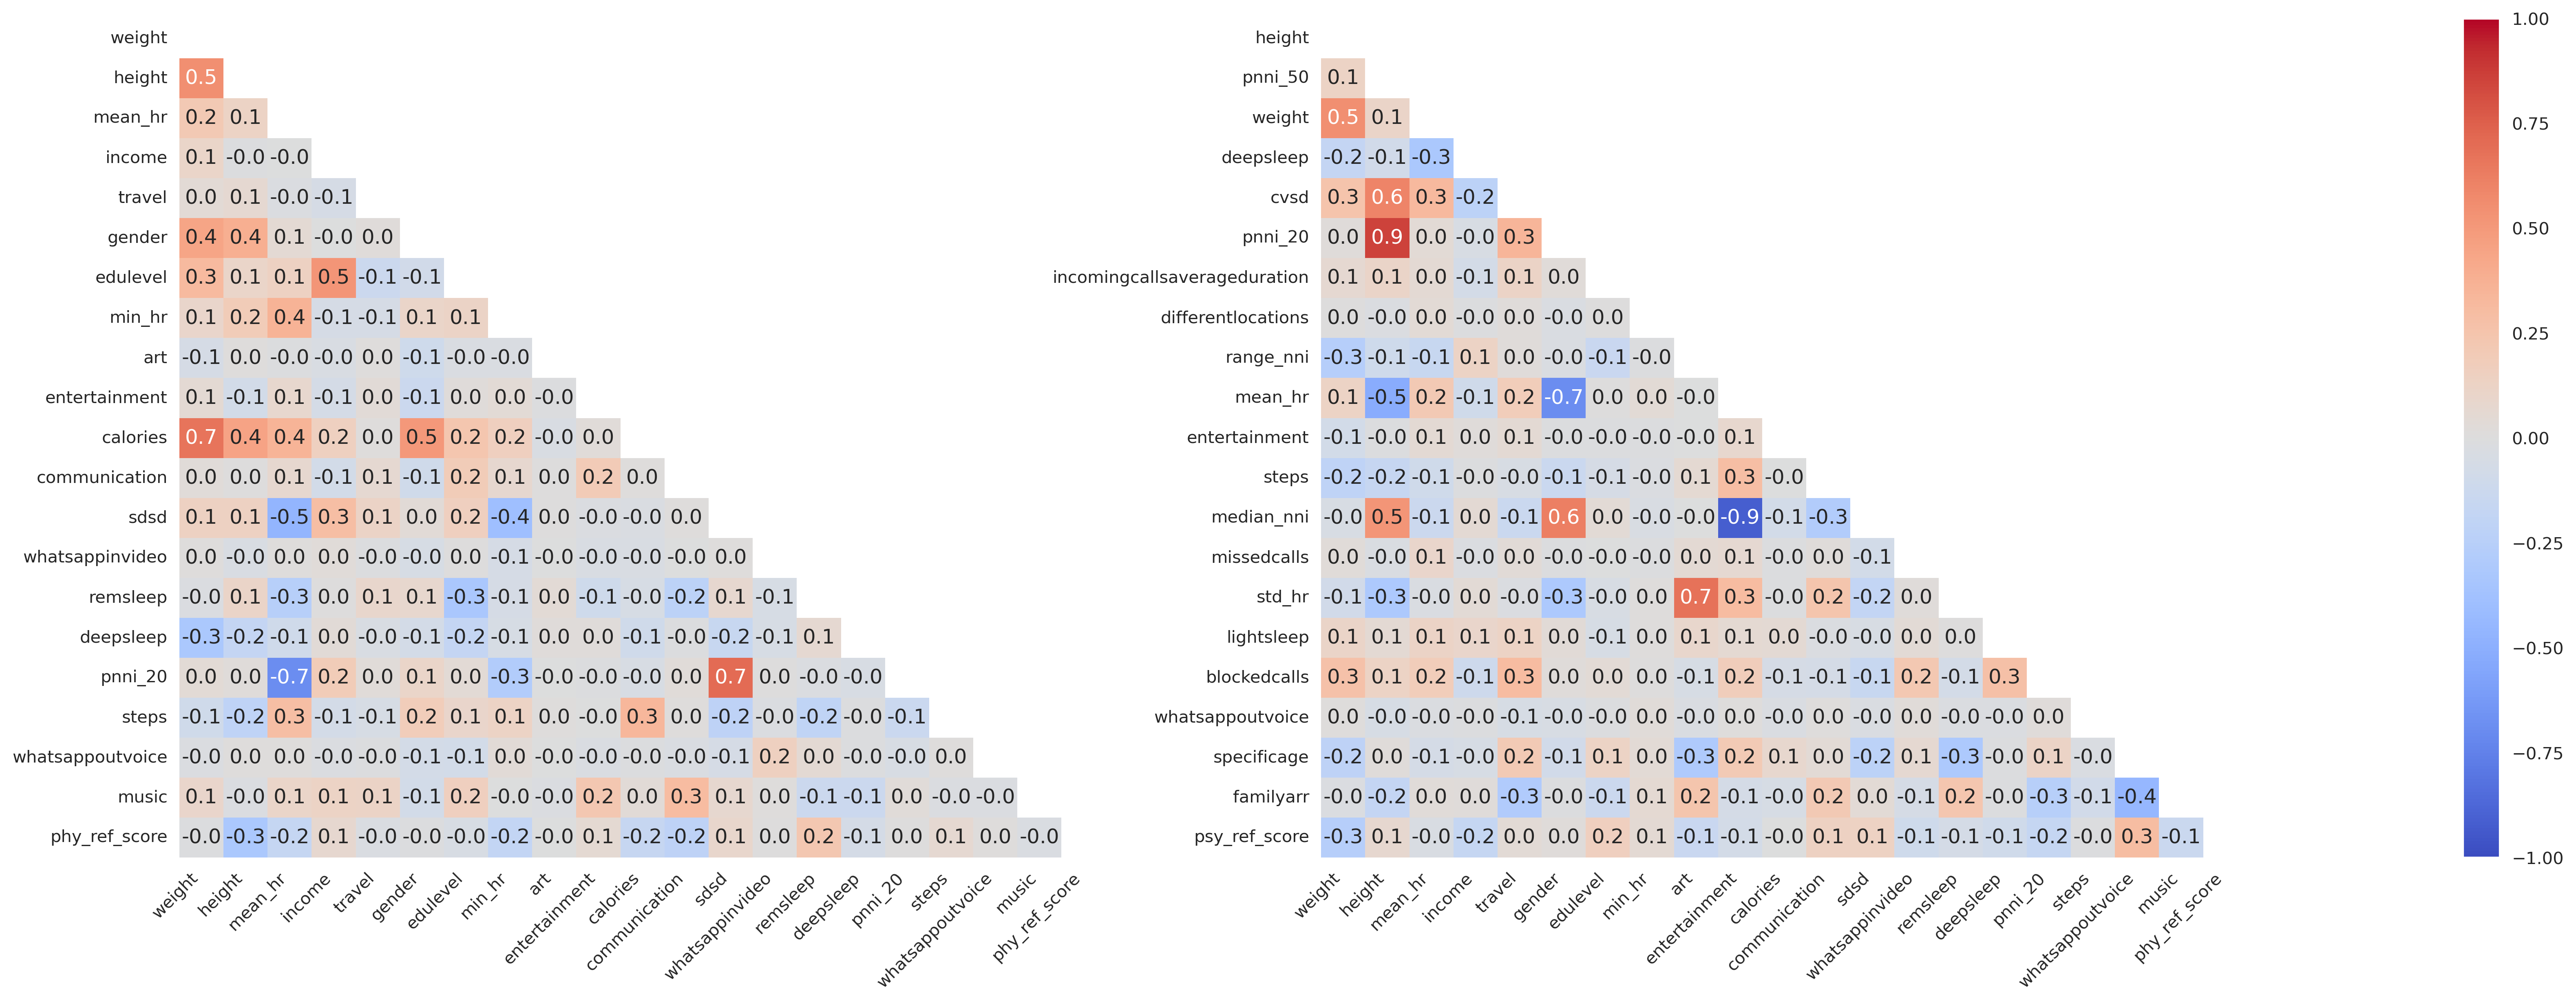

In [27]:
buildPearsonCorrelationMatrix(df_phy_20_most, df_psy_20_most, 'pearson', 'feat-correlations.pdf')